In [1]:
# Install & import Prophet
try:
    from prophet import Prophet
except ImportError:
    !pip install prophet --quiet
    !pip install --upgrade setuptools wheel --quiet
    from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# Geo stack
from geopy.distance import geodesic


# Other imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
# Charging stations (French)
charging_df = pd.read_csv("/content/ev_charging_stations_canada_French.csv")

# EV registration stats
registration_df = pd.read_csv("/content/ev_registration_statscan.csv")

# Census Profile 2021
census_df = pd.read_csv("/content/Census_Cleaned.csv")

In [3]:
# View first few rows of each
print("EV Charging Stations")
display(charging_df.head())

print("\nEV Registration Stats")
display(registration_df.head())

print("\nCensus Profile 2021")
display(census_df.head())

EV Charging Stations


,NOM_BORNE_RECHARGE,NOM_PARC,ADRESSE,VILLE,PROVINCE,NIVEAU_RECHARGE,MODE_TARIFICATION,TYPE_EMPLACEMENT,LONGITUDE,LATITUDE
0,CEA-10190,1019 | BSR | AC | 10905 rue Basile-Routhier :...,10905A rue Basile Routhier Montréal QC H2C 3H5,Montréal,QC,Niveau 2,par heure,NaN,-73.671649,45.557084
1,CEA-10198,1019 | BSR | AC | 10905 rue Basile-Routhier :...,10905A rue Basile Routhier Montréal QC H2C 3H5,Montréal,QC,Niveau 2,par heure,NaN,-73.671649,45.557084
2,CEA-11344,1020 | BSR | AC | 2503 Henri-Bourassa E.,2503 Henri-Bourassa E. Montréal QC H2B 1V1,Montréal,QC,Niveau 2,par heure,NaN,-73.653820,45.578369
3,CEA-11860,1020 | BSR | AC | 2503 Henri-Bourassa E.,2503 Henri-Bourassa E. Montréal QC H2B 1V1,Montréal,QC,Niveau 2,par heure,NaN,-73.653820,45.578369
4,CEA-11922,1021 | BSR | AC | 10940 St-Laurent,10940 Boul St-Laurent Montréal QC H3L 2R1,Montréal,QC,Niveau 2,par heure,sur rue,-73.675833,45.551740



EV Registration Stats


,Province,City/CMA,Vehicle type,Statistics,Q1 2017,Q2 2017,Q3 2017,Q4 2017,Q1 2018,Q2 2018,...,Q4 2022.2,Q1 2023.2,Q2 2023.2,Q3 2023.2,Q4 2023.2,Q1 2024.2,Q2 2024.2,Q3 2024.2,Q4 2024.2,Q1 2025.2
0,Quebec,Québec,Passenger cars,Number of vehicles,131,241,218,293,235,487,...,41,8,22,60,77,74,32,91,135,36
1,Quebec,Québec,Pickup trucks 2,Number of vehicles,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Quebec,Québec,Multi-purpose vehicles 3,Number of vehicles,25,24,14,30,71,121,...,203,280,555,669,753,623,902,"1,058","1,051",267
3,Quebec,Montréal,Passenger cars,Number of vehicles,473,794,818,"1,005",932,"1,883",...,173,43,158,352,269,393,222,470,512,199
4,Quebec,Montréal,Pickup trucks 2,Number of vehicles,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Census Profile 2021


,Topic,Characteristic,Note,Total,Men+,Women+,Total.1,Men+.1,Women+.1,Total.2,...,Women+.8,Total.9,Men+.9,Women+.9,Total.10,Men+.10,Women+.10,Total.11,Men+.11,Women+.11
0,Population and dwellings,"Population, 2021",1.0,1017449.0,NaN,NaN,NaN,NaN,NaN,2794356.0,...,NaN,NaN,NaN,NaN,91867.0,NaN,NaN,NaN,NaN,NaN
1,Population and dwellings,"Population, 2016",1.0,934243.0,NaN,NaN,NaN,NaN,NaN,2731571.0,...,NaN,NaN,NaN,NaN,85792.0,NaN,NaN,NaN,NaN,NaN
2,Population and dwellings,"Population percentage change, 2016 to 2021",NaN,8.9,NaN,NaN,8.9,NaN,NaN,2.3,...,NaN,4.9,NaN,NaN,7.1,NaN,NaN,7.1,NaN,NaN
3,Population and dwellings,Total private dwellings,2.0,427113.0,NaN,NaN,NaN,NaN,NaN,1253238.0,...,NaN,NaN,NaN,NaN,53070.0,NaN,NaN,NaN,NaN,NaN
4,Population and dwellings,Private dwellings occupied by usual residents,3.0,407252.0,NaN,NaN,NaN,NaN,NaN,1160892.0,...,NaN,NaN,NaN,NaN,49222.0,NaN,NaN,NaN,NaN,NaN


In [4]:
# Rename columns to English
charging_df.rename(columns={
    'NOM_BORNE_RECHARGE': 'Charger_Name',
    'VILLE': 'City',
    'PROVINCE': 'Province',
    'NIVEAU_RECHARGE': 'Charging_Level',
    'LONGITUDE': 'Longitude',
    'LATITUDE': 'Latitude',
    'NOM_PARC': 'Parking_Lot_Name',
    'ADRESSE': 'Address',
    'MODE_TARIFICATION': 'Pricing_Model',
    'TYPE_EMPLACEMENT': 'Location_Type'
}, inplace=True)

charging_df['Charging_Level'] = charging_df['Charging_Level'].replace({
    'Niveau 1': 'Level 1',
    'Niveau 2': 'Level 2',
    'Niveau 3': 'Level 3'
})

charging_df['Pricing_Model'] = charging_df['Pricing_Model'].replace({
    'par heure': 'per hour',
    'gratuit': 'free',
    'par session': 'per session'
})

charging_df['Location_Type'] = charging_df['Location_Type'].replace({
    'sur rue': 'on street',
    'stationnement': 'parking lot',
    'privé': 'private',
    'public': 'public'
})

# Drop exact coordinate duplicates
charging_df.drop_duplicates(subset=['Longitude', 'Latitude'], inplace=True)

# Fix missing data for location type
charging_df['Location_Type'] = charging_df['Location_Type'].fillna('Unknown')

charging_df.info()
charging_df.isna().sum()

print("EV Charging Stations")
display(charging_df.head(1000))

<class 'pandas.core.frame.DataFrame'>
Index: 813 entries, 0 to 2090
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Charger_Name      813 non-null    object 
 1   Parking_Lot_Name  813 non-null    object 
 2   Address           813 non-null    object 
 3   City              813 non-null    object 
 4   Province          813 non-null    object 
 5   Charging_Level    813 non-null    object 
 6   Pricing_Model     813 non-null    object 
 7   Location_Type     813 non-null    object 
 8   Longitude         813 non-null    float64
 9   Latitude          813 non-null    float64
dtypes: float64(2), object(8)
memory usage: 69.9+ KB
EV Charging Stations


,Charger_Name,Parking_Lot_Name,Address,City,Province,Charging_Level,Pricing_Model,Location_Type,Longitude,Latitude
0,CEA-10190,1019 | BSR | AC | 10905 rue Basile-Routhier :...,10905A rue Basile Routhier Montréal QC H2C 3H5,Montréal,QC,Level 2,per hour,Unknown,-73.671649,45.557084
2,CEA-11344,1020 | BSR | AC | 2503 Henri-Bourassa E.,2503 Henri-Bourassa E. Montréal QC H2B 1V1,Montréal,QC,Level 2,per hour,Unknown,-73.653820,45.578369
4,CEA-11922,1021 | BSR | AC | 10940 St-Laurent,10940 Boul St-Laurent Montréal QC H3L 2R1,Montréal,QC,Level 2,per hour,on street,-73.675833,45.551740
6,CEA-12067,1022 | BSR | AC | 9494 Papineau,9490 papineau Montréal QC H2M 1Z3,Montréal,QC,Level 2,per hour,on street,-73.642342,45.563199
8,CEA-11204,1023 | BSR | AC | 8340 Papineau,8340 Avenue Papineau Montréal QC H2M 2R5,Montréal,QC,Level 2,per hour,on street,-73.624298,45.555275
...,...,...,...,...,...,...,...,...,...,...
2080,CEA-12442,Montréal-Est - Hôtel de Ville,11370 rue Notre-Dame Montréal-Est QC H1B 2W6,Montréal-Est,QC,Level 2,per hour,Unknown,-73.495262,45.631032
2082,CEA-11656,Montréal-Est – Parc - Hôtel de Ville,11370 rue Notre-Dame Montréal-Est QC H1B 2W6,Montréal-Est,QC,Level 2,per hour,Unknown,-73.494951,45.630818
2086,CEA-11991,Westmount - Stationnement municipal Greene,1368 Av. Greene Westmount QC H3Z 2B1,Westmount,QC,Level 2,per hour,Unknown,-73.591454,45.487284
2088,CEA-11641,Westmount - Stationnement public Tupper,1156 Av. Greene Westmount QC H3Z 1P4,Westmount,QC,Level 2,per hour,Unknown,-73.587047,45.486143


In [5]:
# Step 1: Filter for EV-relevant vehicle types
ev_types = ['Passenger cars', 'Multi-purpose vehicles 3']
registration_df = registration_df[registration_df['Vehicle type'].isin(ev_types)]

# Make a copy to avoid Setting With CopyWarning
registration_df = registration_df.copy()

# Step 2: Rename 'City/CMA' to 'City'
registration_df.rename(columns={'City/CMA': 'City'}, inplace=True)

# Step 3: Replace 'Ottawa - Gatineau' with 'Ottawa'
registration_df['City'] = registration_df['City'].replace({'Ottawa - Gatineau': 'Ottawa'})

# Step 4: Drop the 'Statistics' column if present
if 'Statistics' in registration_df.columns:
    registration_df = registration_df.drop(columns=['Statistics'])

# Step 5: Identify Quarter columns automatically
quarter_columns = [col for col in registration_df.columns if re.match(r'^Q[1-4] \d{4}$', col)]
print(f"Detected {len(quarter_columns)} quarter columns: {quarter_columns[:5]}...")

# Step 6: Melt the DataFrame to long format
registration_df_long = registration_df.melt(
    id_vars=['Province', 'City', 'Vehicle type'],
    value_vars=quarter_columns,
    var_name='Quarter',
    value_name='EV_Count'
)

# Step 7: Clean 'Quarter' and convert to Period
quarter_extracted = registration_df_long['Quarter'].str.extract(r'Q([1-4]) (\d{4})')
registration_df_long = registration_df_long[quarter_extracted.notnull().all(axis=1)].copy()
registration_df_long['Quarter'] = quarter_extracted[1] + 'Q' + quarter_extracted[0]
registration_df_long['Quarter'] = pd.PeriodIndex(registration_df_long['Quarter'], freq='Q')

# Step 8: Clean column names
registration_df_long.rename(columns={
    'Vehicle type': 'Vehicle_Type'
}, inplace=True)

# Step 9: Ensure EV_Count is numeric
registration_df_long['EV_Count'] = (
    registration_df_long['EV_Count']
    .astype(str)
    .str.replace(',', '', regex=False)
    .replace('', '0')
    .astype(int)
)

# Step 10: Final check
print("\n Cleaned Data Preview:")
print(registration_df_long.head(500))
print("\n Data Types:")
print(registration_df_long.dtypes)

Detected 33 quarter columns: ['Q1 2017', 'Q2 2017', 'Q3 2017', 'Q4 2017', 'Q1 2018']...

 Cleaned Data Preview:
             Province       City              Vehicle_Type Quarter  EV_Count
0              Quebec     Québec            Passenger cars  2017Q1       131
1              Quebec     Québec  Multi-purpose vehicles 3  2017Q1        25
2              Quebec   Montréal            Passenger cars  2017Q1       473
3              Quebec   Montréal  Multi-purpose vehicles 3  2017Q1       107
4             Ontario     Ottawa            Passenger cars  2017Q1       116
..                ...        ...                       ...     ...       ...
391           Ontario    Toronto  Multi-purpose vehicles 3  2025Q1      4794
392  British Columbia  Vancouver            Passenger cars  2025Q1       902
393  British Columbia  Vancouver  Multi-purpose vehicles 3  2025Q1      4935
394  British Columbia   Victoria            Passenger cars  2025Q1        88
395  British Columbia   Victoria  Multi-p

In [6]:
# Static columns
static_cols = ['Topic', 'Characteristic', 'Note']

# City order as they appear in your file
city_names = ['Ottawa', 'Toronto', 'Québec', 'Montréal', 'Vancouver', 'Victoria']

# Identify all value columns AFTER the 3 descriptor columns
value_cols = census_df.columns[len(static_cols):].tolist()

# Build 6-column blocks per city: [counts triple] + [percents triple]
# We will KEEP ONLY the first 3 columns (counts) in each 6-col block.
blocks = [value_cols[i:i+6] for i in range(0, len(value_cols), 6)]

if len(blocks) != len(city_names):
    raise ValueError(
        f"Expected {len(city_names)} city blocks, but found {len(blocks)}. "
        "Check the census file structure / city order."
    )

# Convert to long format using counts-only triple
records = []
for city, six_cols in zip(city_names, blocks):
    count_triplet = six_cols[:3]  # [Total, Men+, Women+] for that city
    temp = census_df[static_cols + count_triplet].copy()
    temp.columns = static_cols + ['Total', 'Men', 'Women']  # rename consistently
    temp['City'] = city
    records.append(temp)

df_long = pd.concat(records, ignore_index=True)

# Clean numeric & text
for col in ['Total', 'Men', 'Women']:
    df_long[col] = pd.to_numeric(df_long[col], errors='coerce')

df_long['Topic'] = df_long['Topic'].astype(str).str.strip()
df_long['Characteristic'] = df_long['Characteristic'].astype(str).str.strip()

# Drop Note if empty
if 'Note' in df_long.columns and df_long['Note'].isna().all():
    df_long = df_long.drop(columns='Note')

# Reorder
df_long = df_long[['City', 'Topic', 'Characteristic', 'Total', 'Men', 'Women']]

# Verify the population row is now complete
pop_check = df_long[
    (df_long['Topic'] == 'Population and dwellings') &
    (df_long['Characteristic'] == 'Population, 2021')
][['City', 'Total']].rename(columns={'Total': 'Population_2021'})
print("\nPopulation, 2021 (counts triple only):")
print(pop_check.sort_values('City'))


# Income extraction
# Primary target for income values
target_topic = 'Income of individuals in 2020'
target_char  = 'Average total income in 2020 among recipients ($)'

income_primary = df_long[
    (df_long['Topic'] == target_topic) &
    (df_long['Characteristic'] == target_char)
][['City', 'Total']].rename(columns={'Total': 'Avg_Income_2020'})

# Fallbacks if the exact rows are missing for some city
if income_primary.empty or income_primary['Avg_Income_2020'].isna().any():
    income_fallback = df_long[
        (df_long['Topic'].str.contains('Income', case=False, na=False)) &
        (df_long['Characteristic'].str.contains(r'Average.*2020.*recipient', case=False, na=False))
    ][['City', 'Characteristic', 'Total']].copy()
    income_fallback['Avg_Income_2020'] = pd.to_numeric(income_fallback['Total'], errors='coerce')
    # pick the largest numeric value per city
    income_fallback = (
        income_fallback.sort_values(['City','Avg_Income_2020'], ascending=[True, False])
        .groupby('City', as_index=False)
        .first()[['City','Avg_Income_2020']]
    )
    # Combine primary & fallback
    income_2020 = (
        income_primary
        .merge(income_fallback, on='City', how='outer', suffixes=('_primary','_fb'))
    )
    income_2020['Avg_Income_2020'] = income_2020['Avg_Income_2020_primary'].fillna(income_2020['Avg_Income_2020_fb'])
    income_2020 = income_2020[['City','Avg_Income_2020']]
else:
    income_2020 = income_primary.copy()

# Clean income range (reasonable 10k–200k)
income_2020['Avg_Income_2020'] = pd.to_numeric(income_2020['Avg_Income_2020'], errors='coerce')
income_2020.loc[~income_2020['Avg_Income_2020'].between(10_000, 200_000), 'Avg_Income_2020'] = np.nan


# Final join

city_stats = (
    pop_check
    .merge(income_2020, on='City', how='outer')
    .sort_values('City')
    .reset_index(drop=True)
)

print("\nPopulation & Income Table:")
print(city_stats)




Population, 2021 (counts triple only):
            City  Population_2021
8508    Montréal        1762949.0
0         Ottawa        1017449.0
5672      Québec         549459.0
2836     Toronto        2794356.0
11344  Vancouver         662248.0
14180   Victoria          91867.0

Population & Income Table:
        City  Population_2021  Avg_Income_2020
0   Montréal        1762949.0          50120.0
1     Ottawa        1017449.0          64500.0
2     Québec         549459.0          52400.0
3    Toronto        2794356.0          62050.0
4  Vancouver         662248.0          62250.0
5   Victoria          91867.0          54500.0


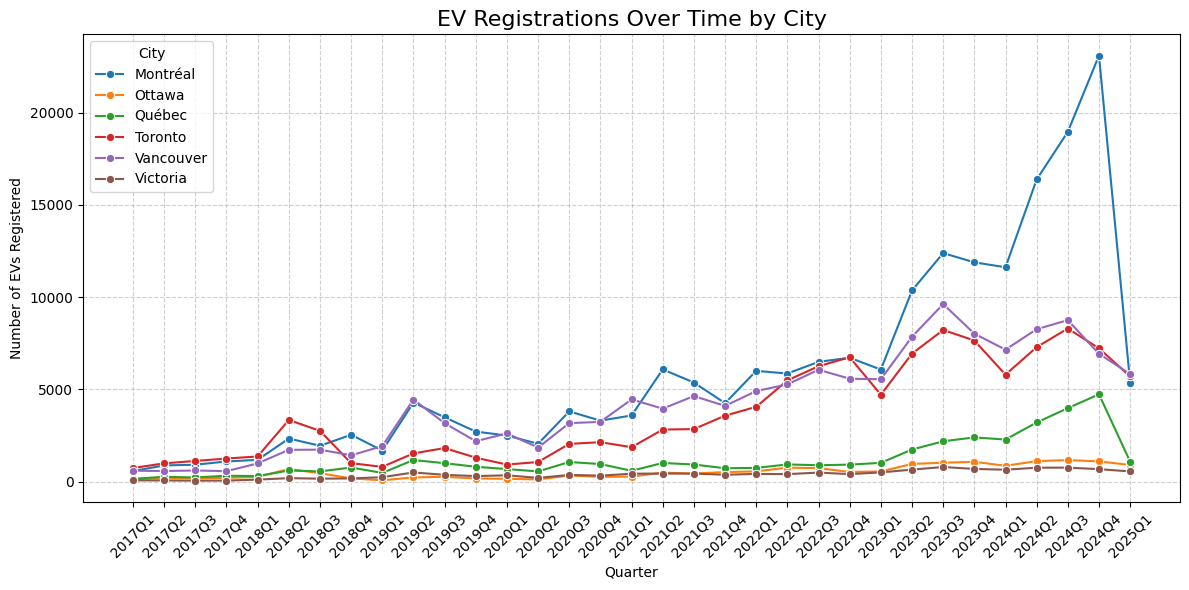

In [7]:
# Q1: EV Registrations Trend Over Time by City

# Group data by quarter and city
ev_trend_city = (
    registration_df_long
    .groupby(['Quarter', 'City'], as_index=False)['EV_Count']
    .sum()
)

# Convert Quarter to string for plotting
ev_trend_city['Quarter'] = ev_trend_city['Quarter'].astype(str)

# Plotting the trend with different colors per city
plt.figure(figsize=(12, 6))
sns.lineplot(data=ev_trend_city, x='Quarter', y='EV_Count', hue='City', marker='o')
plt.title('EV Registrations Over Time by City', fontsize=16)
plt.xlabel('Quarter')
plt.ylabel('Number of EVs Registered')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3664294101.py:12: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(ts['Quarter']):


Cities to forecast: ['Montréal', 'Ottawa', 'Québec', 'Toronto', 'Vancouver', 'Victoria']

City: Montréal  (data points: 33)


DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/2j4o7aei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/oi9j1nsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23490', 'data', 'file=/tmp/tmptjvb5oty/2j4o7aei.json', 'init=/tmp/tmptjvb5oty/oi9j1nsp.json', 'output', 'file=/tmp/tmptjvb5oty/prophet_modelicbijb0d/prophet_model-20250825023842.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:38:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:38:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


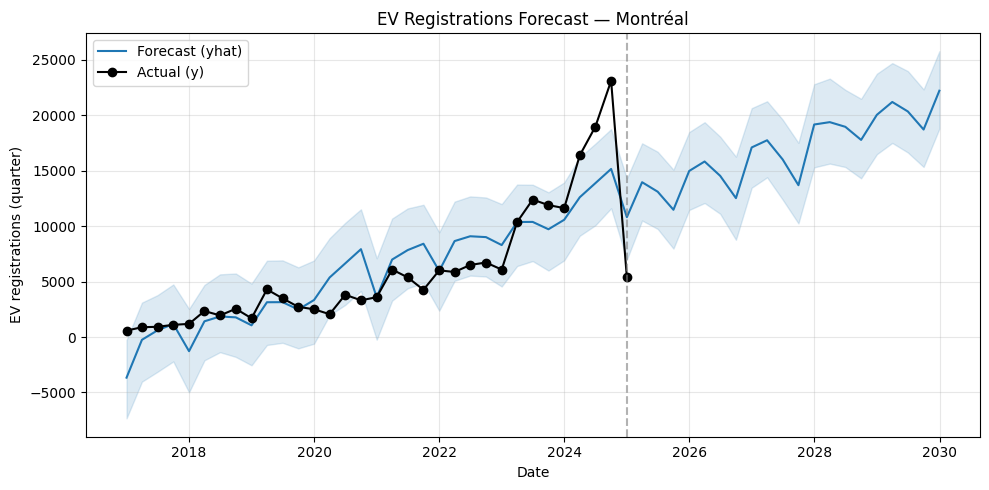

DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/_wndyl0l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/qkjnhr7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24810', 'data', 'file=/tmp/tmptjvb5oty/_wndyl0l.json', 'init=/tmp/tmptjvb5oty/qkjnhr7c.json', 'output', 'file=/tmp/tmptjvb5oty/prophet_model1tyw2ss3/prophet_model-20250825023843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:38:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:38:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



City: Ottawa  (data points: 33)


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


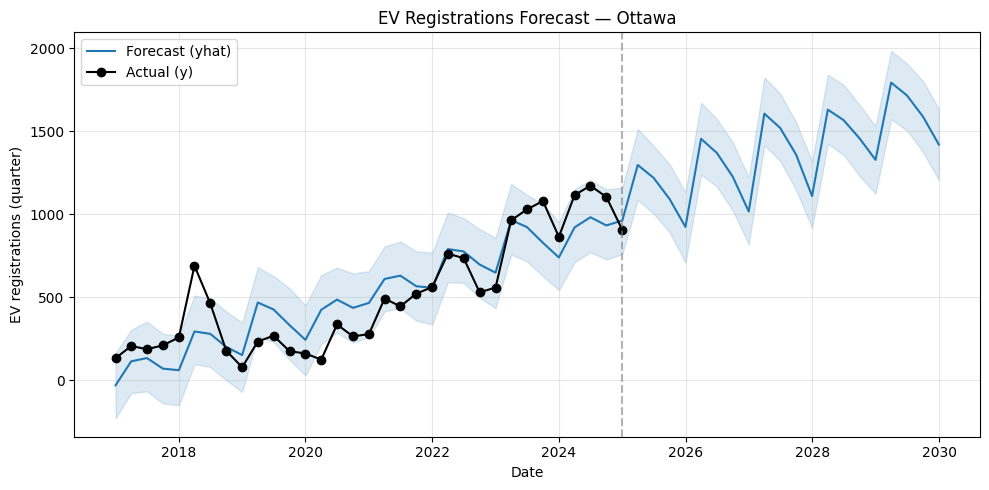

DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/h7m8zpb9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/b07vuozf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80471', 'data', 'file=/tmp/tmptjvb5oty/h7m8zpb9.json', 'init=/tmp/tmptjvb5oty/b07vuozf.json', 'output', 'file=/tmp/tmptjvb5oty/prophet_modelx1l9tz3o/prophet_model-20250825023843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:38:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



City: Québec  (data points: 33)


02:38:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


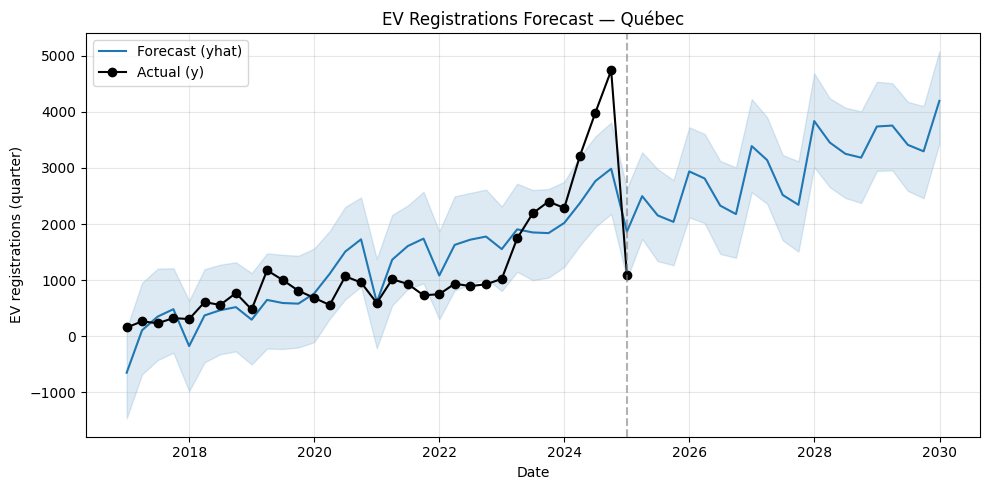

DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/r7d42zt0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/d6om4efn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60097', 'data', 'file=/tmp/tmptjvb5oty/r7d42zt0.json', 'init=/tmp/tmptjvb5oty/d6om4efn.json', 'output', 'file=/tmp/tmptjvb5oty/prophet_model3bov9tcg/prophet_model-20250825023844.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:38:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



City: Toronto  (data points: 33)


02:38:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


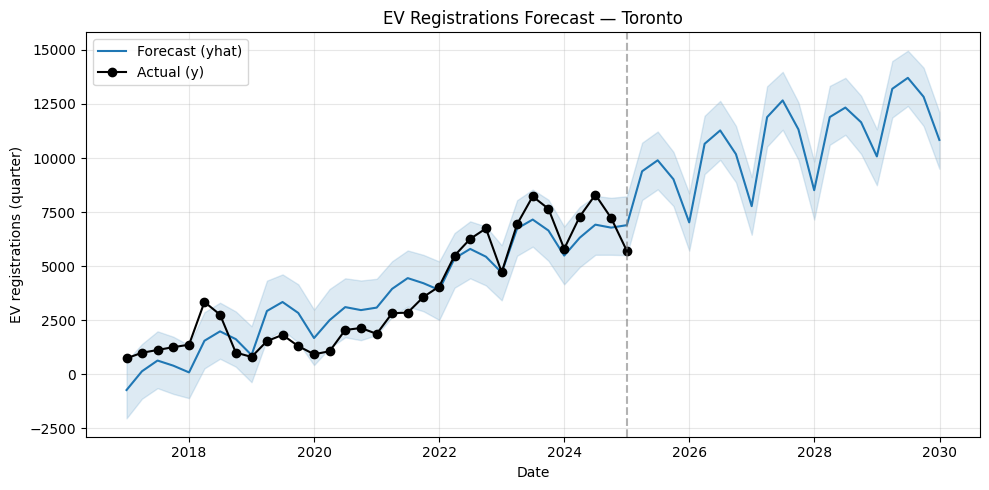

DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/ab8rzrkh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/dewmoeex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15278', 'data', 'file=/tmp/tmptjvb5oty/ab8rzrkh.json', 'init=/tmp/tmptjvb5oty/dewmoeex.json', 'output', 'file=/tmp/tmptjvb5oty/prophet_modeloghrphl6/prophet_model-20250825023845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:38:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



City: Vancouver  (data points: 33)


02:38:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


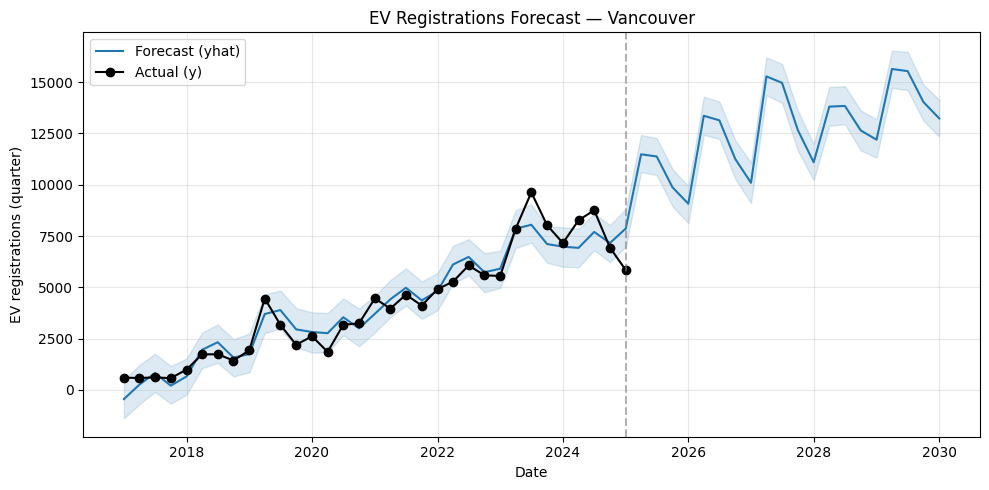

DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/7h937y0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptjvb5oty/0dybvsqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3107', 'data', 'file=/tmp/tmptjvb5oty/7h937y0_.json', 'init=/tmp/tmptjvb5oty/0dybvsqg.json', 'output', 'file=/tmp/tmptjvb5oty/prophet_modeldf6ep6pf/prophet_model-20250825023845.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:38:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



City: Victoria  (data points: 33)


02:38:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


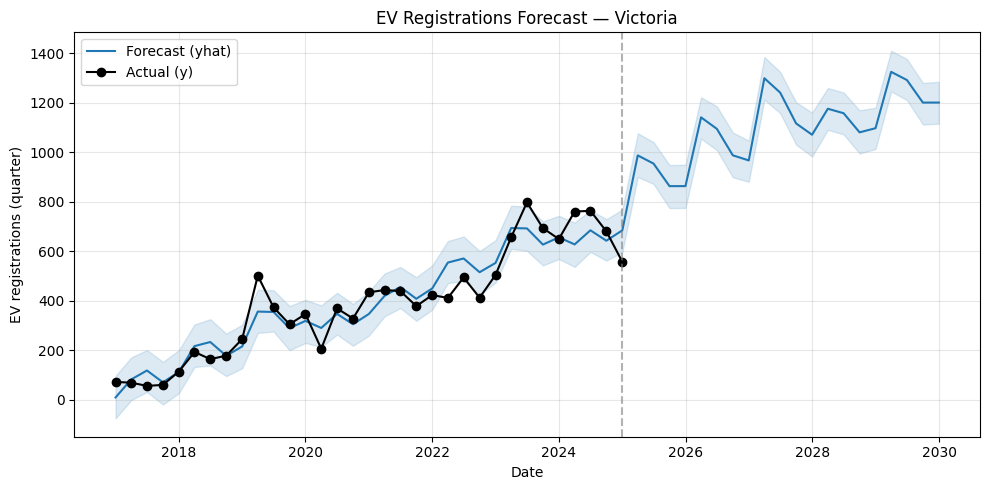


Saved combined forecasts to /content/ev_forecasts_5yrs_quarters_by_city.csv


In [8]:
#Q2: What is the forecasted EV demand in each City over the next 5 years?
# Prepare time series (group by City & Quarter)

ts = (
    registration_df_long
    .groupby(['City', 'Quarter'], as_index=False)['EV_Count']
    .sum()
)

# Convert Quarter (period) to a datetime column Prophet accepts (use quarter start)
# If Quarter is already PeriodDtype, use .dt.to_timestamp(); otherwise try parsing
if pd.api.types.is_period_dtype(ts['Quarter']):
    ts['ds'] = ts['Quarter'].dt.to_timestamp()
else:
    # Attempt to parse strings like "2017Q1"
    ts['ds'] = ts['Quarter'].astype(str).apply(lambda x: pd.Period(x).to_timestamp())

ts = ts.rename(columns={'EV_Count': 'y'})  # Prophet expects 'ds' and 'y'

# Forecast settings
horizon_quarters = 5 * 4  # 5 years * 4 quarters = 20 quarters
min_points_required = 8    # skip cities with fewer than these many quarters of data

all_forecasts = []  # collect per-city forecasts (dataframes)
os.makedirs('/content/forecasts', exist_ok=True)

cities = ts['City'].unique()
print("Cities to forecast:", list(cities))

for city in cities:
    city_df = ts[ts['City'] == city].sort_values('ds').reset_index(drop=True)[['ds','y']]
    n_points = len(city_df)
    print(f"\nCity: {city}  (data points: {n_points})")
    if n_points < min_points_required:
        print(f"  → Skipping {city}: not enough historical points (need >= {min_points_required})")
        continue

    # Fit Prophet
    m = Prophet(
        yearly_seasonality=True,   # quarterly data often has seasonal/annual effects
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive'
    )

    try:
        m.fit(city_df)
    except Exception as e:
        print("  → Model fit failed for", city, ":", e)
        continue

    # Create future dataframe: periods = horizon_quarters, freq = 'Q' (quarterly)
    try:
        future = m.make_future_dataframe(periods=horizon_quarters, freq='Q')
    except Exception:
        # fallback: use quarterly start frequency
        future = m.make_future_dataframe(periods=horizon_quarters, freq='QS')

    # Predict
    forecast = m.predict(future)

    # Keep only relevant columns and annotate with city
    forecast_small = forecast[['ds','yhat','yhat_lower','yhat_upper']].copy()
    forecast_small['City'] = city

    # Merge actuals for plotting convenience
    merged = pd.merge(forecast_small, city_df.rename(columns={'y':'y_actual'}), on='ds', how='left')

    # Save per-city forecast CSV
    forecast_small.to_csv(f'/content/forecasts/forecast_{city.replace(" ", "_")}.csv', index=False)

    # Append to list
    all_forecasts.append(forecast_small)

    # Plot actual (historical) vs forecast for this city
    plt.figure(figsize=(10,5))
    plt.plot(merged['ds'], merged['yhat'], label='Forecast (yhat)', color='tab:blue')
    plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='tab:blue', alpha=0.15)
    plt.plot(merged['ds'], merged['y_actual'], label='Actual (y)', marker='o', linestyle='-', color='black')
    plt.axvline(city_df['ds'].max(), color='gray', linestyle='--', alpha=0.6)  # training cutoff
    plt.title(f'EV Registrations Forecast — {city}')
    plt.xlabel('Date')
    plt.ylabel('EV registrations (quarter)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Combine forecasts for all cities into one DataFrame & save
if all_forecasts:
    combined = pd.concat(all_forecasts, ignore_index=True)
    # reorder columns
    combined = combined[['City','ds','yhat','yhat_lower','yhat_upper']]
    combined.to_csv('/content/ev_forecasts_5yrs_quarters_by_city.csv', index=False)
    print("\nSaved combined forecasts to /content/ev_forecasts_5yrs_quarters_by_city.csv")
else:
    print("No forecasts produced (maybe all cities had too few points).")


EV + City Stats Table:
        City  Population_2021  Avg_Income_2020  Total_EV
0   Montréal        1762949.0          50120.0    195919
1     Ottawa        1017449.0          64500.0     17050
2     Québec         549459.0          52400.0     39389
3    Toronto        2794356.0          62050.0    119795
4  Vancouver         662248.0          62250.0    137895
5   Victoria          91867.0          54500.0     13072


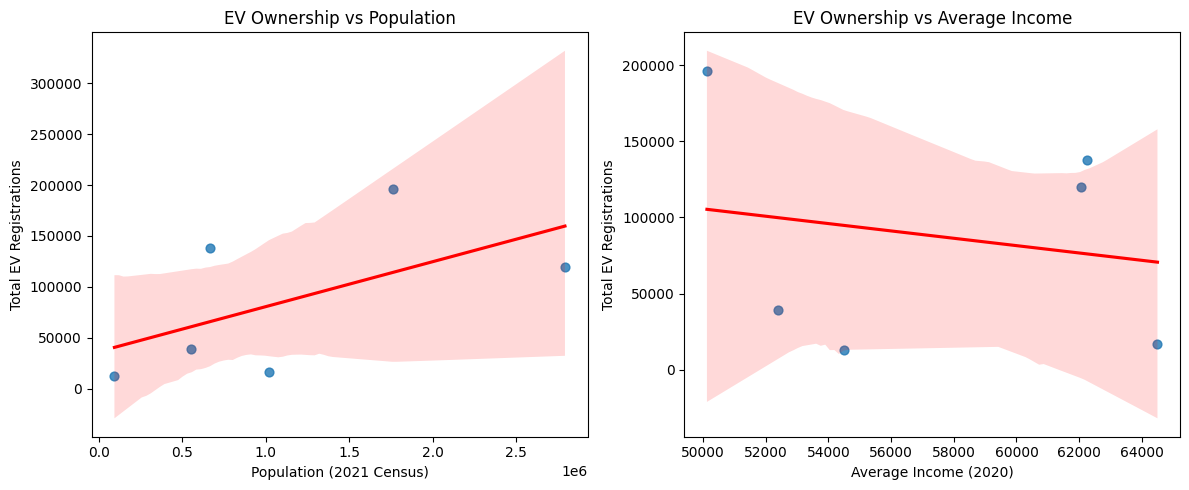


Correlation Matrix:
                  Total_EV  Population_2021  Avg_Income_2020
Total_EV         1.000000         0.575662        -0.193717
Population_2021  0.575662         1.000000         0.201319
Avg_Income_2020 -0.193717         0.201319         1.000000


In [9]:
# Q3: How does EV ownership relate to population and income in each city?
# Aggregate EV registrations per city
ev_city_totals = (
    registration_df_long
    .groupby('City', as_index=False)['EV_Count']
    .sum()
    .rename(columns={'EV_Count': 'Total_EV'})
)

# Merge with city_stats (Population + Income)
ev_city_stats = (
    city_stats
    .merge(ev_city_totals, on='City', how='left')
    .fillna({'Total_EV': 0})
)

print("EV + City Stats Table:")
print(ev_city_stats)

# Plot EV vs Population and EV vs Avg Income
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# EV vs Population
sns.regplot(
    x='Population_2021', y='Total_EV', data=ev_city_stats, ax=axes[0],
    scatter_kws={'s': 40}, line_kws={'color': 'red'}
)
axes[0].set_xlabel('Population (2021 Census)')
axes[0].set_ylabel('Total EV Registrations')
axes[0].set_title('EV Ownership vs Population')

# EV vs Average Income
sns.regplot(
    x='Avg_Income_2020', y='Total_EV', data=ev_city_stats, ax=axes[1],
    scatter_kws={'s': 40}, line_kws={'color': 'red'}
)
axes[1].set_xlabel('Average Income (2020)')
axes[1].set_ylabel('Total EV Registrations')
axes[1].set_title('EV Ownership vs Average Income')

plt.tight_layout()
plt.show()

# Correlation matrix
corr_df = ev_city_stats[['Total_EV', 'Population_2021', 'Avg_Income_2020']].corr()
print("\nCorrelation Matrix:\n", corr_df)


EV Penetration Table:
         City  Total_EV  Population_2021  EV_per_1000
0  Vancouver    137895         662248.0   208.222599
1   Victoria     13072          91867.0   142.292662
2   Montréal    195919        1762949.0   111.131405
3     Québec     39389         549459.0    71.686877
4    Toronto    119795        2794356.0    42.870343
5     Ottawa     17050        1017449.0    16.757597


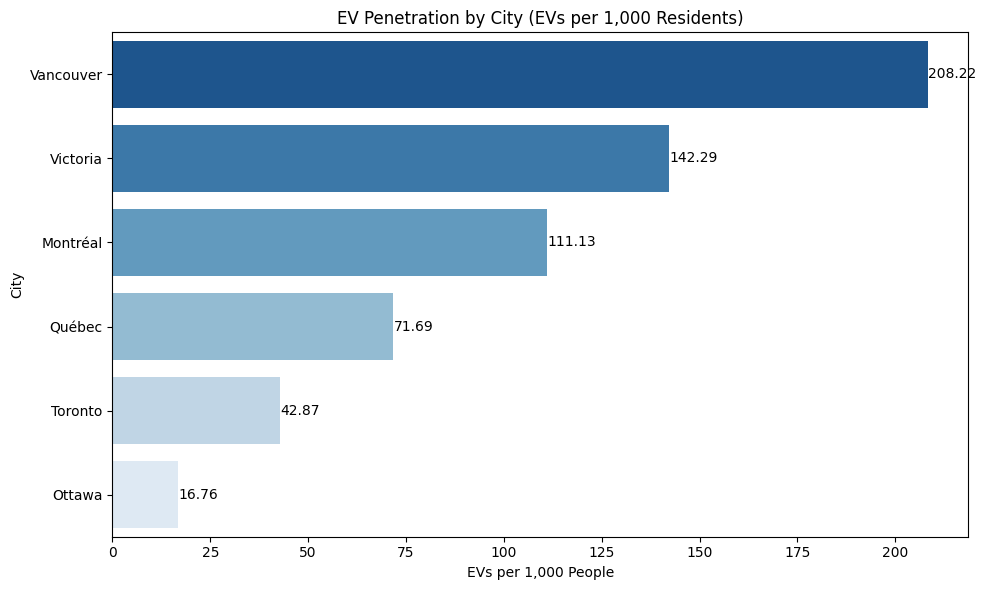

In [10]:
# Q4: Which CMAs have the highest EV-to-population ratios (EV penetration)?
# Calculate EV Penetration
ev_penetration = (
    ev_city_totals
    .merge(city_stats[['City', 'Population_2021']], on='City', how='left')
    .assign(EV_per_1000=lambda df: (df['Total_EV'] / df['Population_2021']) * 1000)
    .sort_values('EV_per_1000', ascending=False)
    .reset_index(drop=True)
)

print("EV Penetration Table:\n", ev_penetration)

# Plot EV Penetration
plt.figure(figsize=(10,6))
sns.barplot(
    x='EV_per_1000',
    y='City',
    data=ev_penetration,
    hue='City',
    dodge=False,       # avoid duplicate bars
    legend=False,      # hide legend (redundant)
    palette='Blues_r'
)

plt.xlabel("EVs per 1,000 People")
plt.ylabel("City")
plt.title("EV Penetration by City (EVs per 1,000 Residents)")

# Annotate bars with exact values
for index, row in ev_penetration.iterrows():
    plt.text(
        row['EV_per_1000'] + 0.1,  # small offset to the right
        index,
        f"{row['EV_per_1000']:.2f}",
        va='center'
    )

plt.tight_layout()
plt.show()

Group Average(6 Cities) EV Penetration: 76.05 EVs per 1,000 People


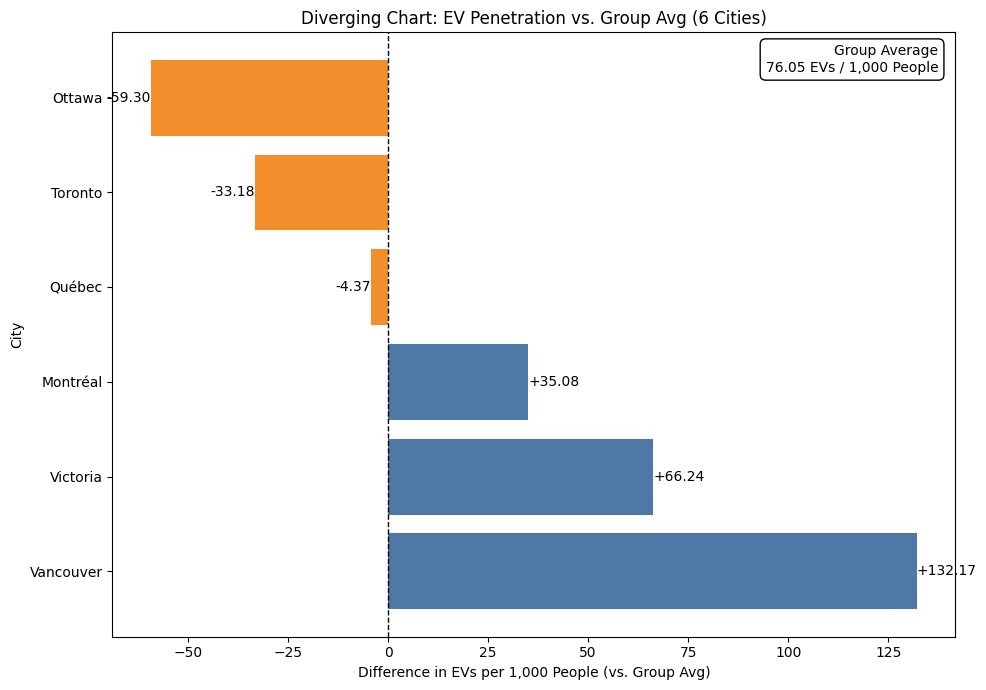

In [11]:
# Q5: High adopter vs. low adopter cities in EV penetration compared to group average
# Calculate Group Average EV per 1,000 People
canada_totals = ev_city_totals['Total_EV'].sum()
canada_population = city_stats['Population_2021'].sum()
canada_avg_ev_per_1000 = (canada_totals / canada_population) * 1000

print(f"Group Average(6 Cities) EV Penetration: {canada_avg_ev_per_1000:.2f} EVs per 1,000 People")

# Extend city table with comparison to group avg
ev_penetration_compare = (
    ev_city_totals
    .merge(city_stats[['City', 'Population_2021']], on='City', how='left')
    .assign(
        EV_per_1000=lambda df: (df['Total_EV'] / df['Population_2021']) * 1000,
        Diff_vs_Canada=lambda df: (df['Total_EV'] / df['Population_2021']) * 1000 - canada_avg_ev_per_1000,
        Category=lambda df: np.where(
            (df['Total_EV'] / df['Population_2021']) * 1000 >= canada_avg_ev_per_1000,
            'High Adopter',
            'Low Adopter'
        )
    )
    .sort_values('EV_per_1000', ascending=False)
    .reset_index(drop=True)
)



# Diverging Bar Chart with Benchmark Average
plt.figure(figsize=(10, 7))

# Diverging: plot difference from group avg
ev_penetration_compare['Color'] = ev_penetration_compare['Category'].map(
    {'High Adopter': '#4e79a7', 'Low Adopter': '#f28e2b'}
)

plt.barh(
    ev_penetration_compare['City'],
    ev_penetration_compare['Diff_vs_Canada'],
    color=ev_penetration_compare['Color']
)

# Add reference line at 0
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Add average info in a box to the top-right
plt.text(
    0.98, 0.98,  # position in axis coordinates
    f"Group Average\n{canada_avg_ev_per_1000:.2f} EVs / 1,000 People",
    transform=plt.gca().transAxes,  # place relative to axes
    fontsize=10,
    ha="right", va="top",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.4")
)

plt.title("Diverging Chart: EV Penetration vs. Group Avg (6 Cities)")
plt.xlabel("Difference in EVs per 1,000 People (vs. Group Avg)")
plt.ylabel("City")

# Annotate bars with values
for idx, row in ev_penetration_compare.iterrows():
    plt.text(
        row['Diff_vs_Canada'], idx, f"{row['Diff_vs_Canada']:+.2f}",
        va='center',
        ha='left' if row['Diff_vs_Canada'] > 0 else 'right'
    )

plt.tight_layout()
plt.show()


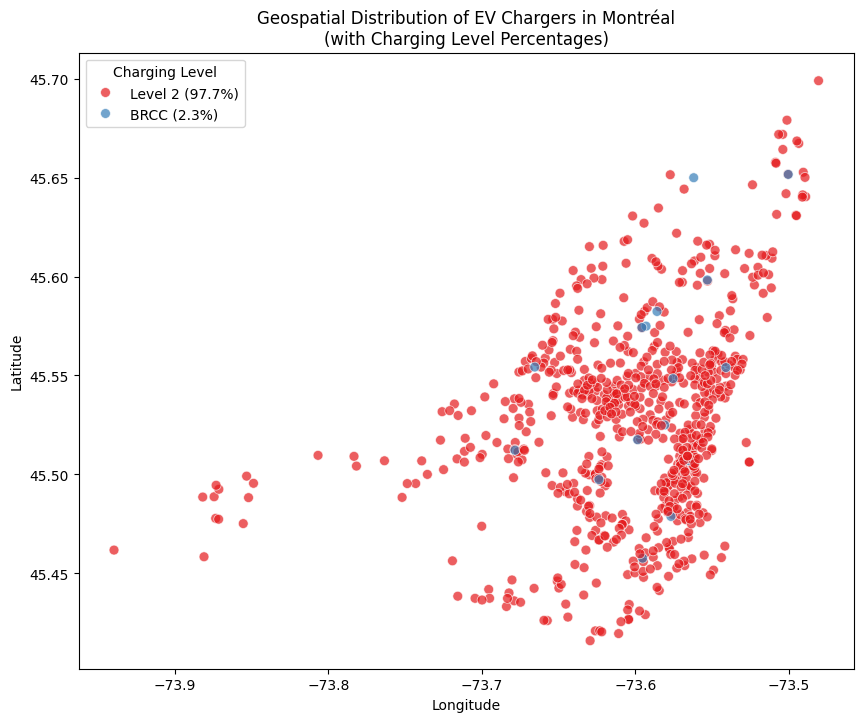

In [12]:
# Q6: How are existing EV chargers distributed across Montreal’s neighborhoods?

# Create one clean Montreal subset
montreal_chargers = charging_df[
    charging_df['City'].str.contains("Montréal", case=False, na=False)
].dropna(subset=['Latitude','Longitude'])


# Distribution by charger type (scatterplot w/ %)
charger_type_perc = montreal_chargers['Charging_Level'].value_counts(normalize=True) * 100
labels_with_pct = {
    lvl: f"{lvl} ({charger_type_perc[lvl]:.1f}%)"
    for lvl in charger_type_perc.index
}

palette = sns.color_palette("Set1", n_colors=len(charger_type_perc))

plt.figure(figsize=(10,8))
sns.scatterplot(
    data=montreal_chargers,
    x="Longitude", y="Latitude",
    hue=montreal_chargers['Charging_Level'].map(labels_with_pct),
    alpha=0.7, s=50, palette=palette
)
plt.title("Geospatial Distribution of EV Chargers in Montréal\n(with Charging Level Percentages)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Charging Level")
plt.show()

Average nearest-charger distance (unique sites) in Montreal: 0.33 km
Median nearest-charger distance (unique sites) in Montreal: 0.26 km


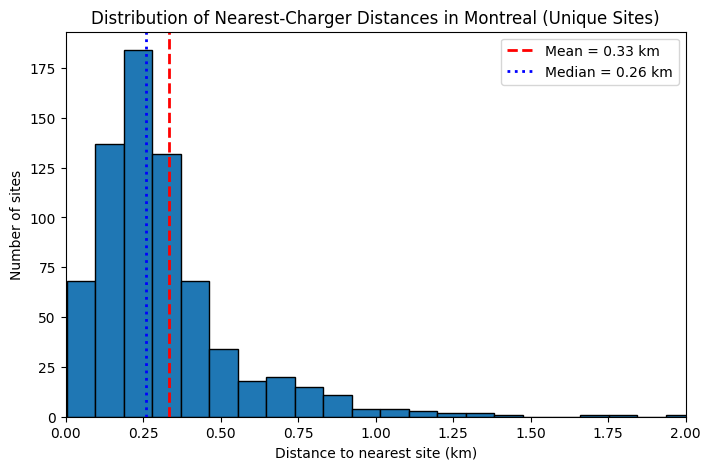

In [13]:
# Q7: What is the average distance to the nearest charger in different parts of Montreal?

# Average nearest-charger distance
# Collapse chargers with same coordinates → unique sites
sites = montreal_chargers[['Latitude', 'Longitude']].drop_duplicates().to_numpy()

distances = []
for i, (lat1, lon1) in enumerate(sites):
    dists = [
        geodesic((lat1, lon1), (lat2, lon2)).km
        for j, (lat2, lon2) in enumerate(sites) if i != j
    ]
    if dists:
        distances.append(min(dists))

avg_distance = np.mean(distances)
median_distance = np.median(distances)

print(f"Average nearest-charger distance (unique sites) in Montreal: {avg_distance:.2f} km")
print(f"Median nearest-charger distance (unique sites) in Montreal: {median_distance:.2f} km")

plt.figure(figsize=(8,5))
plt.hist(distances, bins=50, edgecolor='black')
plt.axvline(avg_distance, color='red', linestyle='dashed', linewidth=2, label=f"Mean = {avg_distance:.2f} km")
plt.axvline(median_distance, color='blue', linestyle='dotted', linewidth=2, label=f"Median = {median_distance:.2f} km")
plt.title("Distribution of Nearest-Charger Distances in Montreal (Unique Sites)")
plt.xlabel("Distance to nearest site (km)")
plt.ylabel("Number of sites")
plt.xlim(0, 2)  # zoom up to 2 km
plt.legend()
plt.show()


In [14]:
# Export the four main datasets for Power BI
charging_df.to_csv("charging_data.csv", index=False)
registration_df_long.to_csv("registration_data.csv", index=False)
city_stats.to_csv("city_stats.csv", index=False)


print("✅ All 4 datasets exported as CSVs for Power BI")


✅ All 4 datasets exported as CSVs for Power BI
